In [240]:
import json
import requests
import os

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
%matplotlib inline

import seaborn as sns

from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.core import Workspace, Environment, Datastore, Dataset

from azure.storage.blob import BlobServiceClient 

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.runconfig import RunConfiguration

In [270]:
pd.set_option('display.max_columns', None)
sns.set_palette("Spectral")
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params);

# Connect to Azure ML Workspace
using our `azure-ml-adls` service principal

In [181]:
# import credentials saved in a local only file 
#    (can also use Azure Key Vault or environment variables for secure keys)
with open('./config.json') as f:
    creds = json.load(f)

svc_pr = ServicePrincipalAuthentication(
    tenant_id=creds['service_principal_tenant_id'],
    service_principal_id=creds['service_principal_app_id'],
    service_principal_password=creds['service_principal_password']
)

ws = Workspace(
    subscription_id=creds['workspace_subscription_id'],
    resource_group=creds['workspace_resource_group'],
    workspace_name=creds['workspace_name'],
    auth=svc_pr # authorize connection using service principal
)

# use our local conda environment created while developing 
myenv = Environment.from_existing_conda_environment(name="rule1", conda_environment_name="rule1investing")

# storage account connection string
storage_connect_str = creds['storage_connection_key']

print("Found workspace {} at location {}".format(ws.name, ws.location))

Exporting conda specifications for existing conda environment: rule1investing
Found workspace cait-projects at location westus2


# Read data from datastore

In [182]:
# retrieve datastore we previously registered in Azure ML
datastore = Datastore.get(ws, "financials")

# ADLS container name
datastore.container_name

'financial-data'

In [183]:
# and get json financial data using azure ml's dataset class
company_profiles_dataset = Dataset.File.from_files(path=[(datastore, 'company_profiles')])

# income sheets
income_dataset = Dataset.File.from_files(path=[(datastore, 'income_sheets')])

# and get json financial data using azure ml's dataset class
balance_dataset = Dataset.File.from_files(path=[(datastore, 'balance_sheets')])

# and get json financial data using azure ml's dataset class
cashflow_dataset = Dataset.File.from_files(path=[(datastore, 'cash_flow')])

In [184]:
data_folder = os.path.join('../', 'data')

# download company profiles
company_profiles_dataset.download(os.path.join(data_folder, 'company_profiles'), overwrite=True)

# download company profiles
income_dataset.download(os.path.join(data_folder, 'income_sheets'), overwrite=True)

# download company profiles
balance_dataset.download(os.path.join(data_folder, 'balance_sheets'), overwrite=True)

# download company profiles
cashflow_dataset.download(os.path.join(data_folder, 'cashflow_dataset'), overwrite=True)

['/mnt/c/Users/caitr/Projects/rule1investing/data/cashflow_dataset/cash_flow_5years_ALK.json',
 '/mnt/c/Users/caitr/Projects/rule1investing/data/cashflow_dataset/cash_flow_5years_DPZ.json']

# Clean and Transform Data

### Create company profiles df

In [303]:
dfs = [] # an empty list to store the data frames

data_dir = os.path.join(data_folder, 'company_profiles')
for file in [os.path.abspath(os.path.join(data_dir, p)) for p in os.listdir(data_dir)]:
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

company_profiles = pd.concat(dfs, ignore_index=True)

### Create income sheets df

In [304]:
dfs = [] # an empty list to store the data frames

data_dir = os.path.join(data_folder, 'income_sheets')
for file in [os.path.abspath(os.path.join(data_dir, p)) for p in os.listdir(data_dir) if not p.startswith('.')]:
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

income_sheets = pd.concat(dfs, ignore_index=True)
income_sheets['fillingDate'] = pd.to_datetime(income_sheets['fillingDate'])
income_sheets['year'] = (income_sheets['fillingDate'] - pd.DateOffset(years=1)).dt.year

In [305]:
income_sheets

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,interestExpense,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink,year
0,2020-12-31,ALK,USD,2021-02-26,2021-02-26 16:26:48,FY,3566000000,3980000000,-414000000,-0.116096,0,0,101000000,-9000000,508000000.0,4488000000,87000000,420000000,-502000000,-0.140774,-922000000,-0.258553,-862000000,-1840000000,-0.515984,-516000000,-1324000000,-0.371284,-10.739866,-10.739866,123279000,123279000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2020
1,2019-12-31,ALK,USD,2020-02-12,2020-02-12 16:03:39,FY,8781000000,6802000000,1979000000,0.225373,0,0,313000000,-26000000,872000000.0,7674000000,63000000,423000000,1530000000,0.174240,1107000000,0.126068,-70000000,1016000000,0.115704,247000000,769000000,0.087575,6.240000,6.190000,123279000,124289000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2019
2,2018-12-31,ALK,USD,2019-02-15,2019-02-15 16:12:29,FY,8264000000,6591000000,1673000000,0.202444,0,0,326000000,-23000000,898000000.0,7489000000,73000000,398000000,1173000000,0.141941,775000000,0.093780,-155000000,585000000,0.070789,148000000,437000000,0.052880,3.550000,3.520000,123230000,123975000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2018
3,2017-12-31,ALK,USD,2018-02-15,2018-02-14 18:02:45,FY,7933000000,5633000000,2300000000,0.289928,0,0,357000000,-1000000,922000000.0,6555000000,86000000,372000000,1750000000,0.220598,1378000000,0.173705,-119000000,1207000000,0.152149,173000000,1034000000,0.130342,7.801032,7.750000,123060638,123870968,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2017
4,2016-12-31,ALK,USD,2017-02-28,2017-02-27 20:14:49,FY,5931000000,3875000000,2056000000,0.346653,0,0,225000000,-1000000,590000000.0,4465000000,30000000,363000000,1829000000,0.308380,1466000000,0.247176,-118000000,1345000000,0.226775,531000000,814000000,0.137245,6.590000,6.540000,123557000,124389000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2016
5,2021-01-03,DPZ,USD,2021-02-25,2021-02-25 07:36:32,FY,4117411000,2522918000,1594493000,0.387256,0,406613000,0,0,406613000.0,2929531000,172166000,65038000,790680000,0.192033,725642000,0.176237,0,555130000,0.134825,63834000,491296000,0.119322,12.610000,12.390000,38960824,39652623,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2020
6,2019-12-29,DPZ,USD,2020-02-20,2020-02-20 07:38:05,FY,3618774000,2216275000,1402499000,0.387562,0,773092000,0,0,773092000.0,2989367000,150818000,59930000,689337000,0.190489,629407000,0.173928,0,482637000,0.133370,81928000,400709000,0.110731,9.830000,9.560000,40763886,41915167,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2019
7,2018-12-30,DPZ,USD,2019-02-21,2019-02-21 07:37:41,FY,3432867000,2130188000,1302679000,0.379473,0,730990000,0,0,730990000.0,2861178000,146345000,53665000,625354000,0.182167,571689000,0.166534,0,428678000,0.124875,66706000,361972000,0.105443,8.650000,8.350000,41846473,43349940,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2018
8,2017-12-31,DPZ,USD,2018-02-20,2018-02-20 07:40:21,FY,2787979000,1921988000,865991000,0.310616,0,344759000,0,0,344759000.0,2266747000,122541000,44369000,565601000,0.202871,521232000,0.186957,0,400153000,0.143528,122248000,277905000,0.099680,6.478224,5.830000,42898329,

### Create balance sheets df

In [306]:
dfs = [] # an empty list to store the data frames

data_dir = os.path.join(data_folder, 'balance_sheets')
for file in [os.path.abspath(os.path.join(data_dir, p)) for p in os.listdir(data_dir) if not p.startswith('.')]:
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

balance_sheets = pd.concat(dfs, ignore_index=True)
balance_sheets['fillingDate'] = pd.to_datetime(balance_sheets['fillingDate'])
balance_sheets['year'] = (balance_sheets['fillingDate'] - pd.DateOffset(years=1)).dt.year

In [307]:
balance_sheets

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,goodwillAndIntangibleAssets,longTermInvestments,taxAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,totalAssets,accountPayables,shortTermDebt,taxPayables,deferredRevenue,otherCurrentLiabilities,totalCurrentLiabilities,longTermDebt,deferredRevenueNonCurrent,deferredTaxLiabilitiesNonCurrent,otherNonCurrentLiabilities,totalNonCurrentLiabilities,otherLiabilities,totalLiabilities,commonStock,retainedEarnings,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalLiabilitiesAndStockholdersEquity,totalInvestments,totalDebt,netDebt,link,finalLink,year
0,2020-12-31,ALK,USD,2021-02-26,2021-02-26 16:26:48,FY,1370000000,1976000000,3346000000,480000000,57000000,660000000,4006000000,7611000000,1943000000,107000000,2050000000,0,0,379000000,10040000000,0,14046000000,108000000,1138000000,0,1806000000,1770000000,4293000000,2357000000,1544000000,407000000,524000000,6765000000,0,11058000000,1000000,3764000000,-494000000,0,2988000000,14046000000,0,3495000000,2125000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2020
1,2019-12-31,ALK,USD,2020-02-12,2020-02-12 16:03:39,FY,221000000,1300000000,1521000000,323000000,72000000,516000000,2037000000,1306000000,1943000000,122000000,2065000000,0,0,278000000,10956000000,0,12993000000,146000000,235000000,0,1650000000,1797000000,3201000000,1264000000,1240000000,715000000,232000000,5461000000,0,8662000000,1000000,5133000000,-465000000,0,4331000000,12993000000,0,1499000000,1278000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2019
2,2018-12-31,ALK,USD,2019-02-15,2019-02-15 16:12:29,FY,105000000,1131000000,1236000000,366000000,60000000,551000000,1787000000,1363000000,1943000000,127000000,2070000000,0,0,274000000,9125000000,0,10912000000,132000000,486000000,0,1493000000,1668000000,2942000000,1617000000,1169000000,512000000,418000000,4219000000,0,7161000000,1000000,4534000000,-448000000,0,3751000000,10912000000,0,2103000000,1998000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2018
3,2017-12-31,ALK,USD,2018-02-15,2018-02-14 18:02:45,FY,194000000,1427000000,1621000000,341000000,57000000,2019000000,2146000000,1222000000,1943000000,133000000,2076000000,0,0,234000000,8594000000,0,10740000000,120000000,307000000,0,937000000,845000000,2700000000,2262000000,699000000,454000000,451000000,4319000000,0,7019000000,1000000,4454000000,-380000000,0,3721000000,10740000000,0,2569000000,2375000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2017
4,2016-12-31,ALK,USD,2017-02-28,2017-02-27 20:14:49,FY,328000000,1252000000,1580000000,302000000,47000000,470000000,2050000000,1103000000,1934000000,143000000,2077000000,0,0,169000000,7912000000,0,9962000000,92000000,319000000,0,849000000,1370000000,2535000000,2645000000,640000000,463000000,417000000,4496000000,0,7031000000,1000000,3568000000,-305000000,0,2931000000,9962000000,0,2964000000,2636000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2016
5,2021-01-03,DPZ,USD,2021-02-25,2021-02-25 07:36:32,FY,168821000,13251000,182072000,244560000,66683000,376069000,869384000,297364000,15061000,0,15061000,13251000,0,0,325676000,372108000,1567168000,94499000,4116018000,0,1904000,0,470819000,2855000,0,0,0,2855000,3923080000,4396754000,389000,0,-2424000,0,-3300405000,1096349000,26502000,4118873000,3950052000,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2020
6,2019-12-29,DPZ,USD,2020-02-20,2020-02-20 07:38:05,FY,190615000,11982000,202597000,210260000,52955000,333787000,7

### Create cash flow df

In [308]:
dfs = [] # an empty list to store the data frames

data_dir = os.path.join(data_folder, 'cashflow_dataset')
for file in [os.path.abspath(os.path.join(data_dir, p)) for p in os.listdir(data_dir) if not p.startswith('.')]:
    data = pd.read_json(file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

cashflow_dataset = pd.concat(dfs, ignore_index=True)
cashflow_dataset['fillingDate'] = pd.to_datetime(cashflow_dataset['fillingDate'])
cashflow_dataset['year'] = (cashflow_dataset['fillingDate'] - pd.DateOffset(years=1)).dt.year

In [309]:
cashflow_dataset

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivities,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,link,finalLink,year
0,2020-12-31,ALK,USD,2021-02-26,2021-02-26 16:26:48,FY,-1324000000,420000000,0,24000000,-201000000,-160000000,0,0,-214000000,220000000,-234000000,-206000000,0,-2962000000,2318000000,257000000,-593000000,-565000000,0,-31000000,-45000000,58000000,1981000000,0,1154000000,1386000000,232000000,-234000000,-206000000,-440000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2020
1,2019-12-31,ALK,USD,2020-02-12,2020-02-12 16:03:39,FY,769000000,423000000,0,29000000,-9000000,43000000,0,0,-1164000000,0,1722000000,-696000000,0,-1810000000,1674000000,41000000,-791000000,-1058000000,0,-75000000,-173000000,43000000,-813000000,0,118000000,232000000,114000000,1722000000,-696000000,1026000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2019
2,2018-12-31,ALK,USD,2019-02-15,2019-02-15 16:12:29,FY,437000000,398000000,0,47000000,-601000000,-25000000,0,0,-1155000000,0,1195000000,-960000000,0,-834000000,1116000000,47000000,-631000000,-807000000,0,-50000000,-158000000,29000000,-647000000,0,-83000000,114000000,197000000,1195000000,-960000000,235000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2018
3,2017-12-31,ALK,USD,2018-02-15,2018-02-14 18:02:45,FY,1034000000,372000000,0,55000000,-69000000,-39000000,0,0,-554000000,0,1590000000,-1026000000,0,-1569000000,1388000000,75000000,-1132000000,-397000000,0,-75000000,-148000000,28000000,-592000000,0,-134000000,194000000,328000000,1590000000,-1026000000,564000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2017
4,2016-12-31,ALK,USD,2017-02-28,2017-02-27 20:14:49,FY,814000000,363000000,0,26000000,-342000000,-46000000,0,0,-485000000,0,1386000000,-678000000,-1951000000,-960000000,962000000,5000000,-2622000000,-249000000,0,-193000000,-136000000,25000000,1491000000,0,255000000,328000000,73000000,1386000000,-678000000,708000000,https://www.sec.gov/Archives/edgar/data/766421...,https://www.sec.gov/Archives/edgar/data/766421...,2016
5,2021-01-03,DPZ,USD,2021-02-25,2021-02-25 07:36:32,FY,491296000,65038000,14424000,24244000,64779000,2134000,-24959000,68954000,398565000,0,592794000,0,0,-40000000,0,0,-128927000,-202058000,0,0,-121925000,0,-446406000,0,-21794000,168821000,190615000,592794000,0,592794000,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2020
6,2019-12-29,DPZ,USD,2020-02-20,2020-02-20 07:38:05,FY,400709000,59930000,-3297000,20265000,146578000,1195000,-6741000,66137000,333786000,2496000,496950000,-85565000,-3000000,-699000000,50152000,706559000,-27854000,-8098000,0,-685943000,-105715000,590021000,-222792000,201000,246505000,271943000,25438000,496950000,-85565000,411385000,https://www.sec.gov/Archives/edgar/data/128668...,https://www.sec.gov/Archives/edgar/data/128668...,2019
7,2018-12-30,DPZ,USD,2019-02-21,2019-02-21 07:37:41,FY,361972000,53665000,-872000,22792000,5713000,-899000,-12455000,10010000,187208000,3201000,394171000,-119888000,0,-591212000,94007000,528836000,-88257000,-8207000,0,-581380000,-92166000,368782000,-322803000,-538000,-17427000,18341000,35768000,394171000,-119888000,274283000,https://www.sec.gov/A

# Create main df

In [328]:
df = income_sheets[['year','symbol','netIncome','revenue','incomeTaxExpense']]\
        .merge(balance_sheets[['year','symbol','totalStockholdersEquity']], on=['year','symbol'], how='left')\
        .merge(cashflow_dataset[['year','symbol','dividendsPaid','operatingCashFlow',
                                 'depreciationAndAmortization','accountsReceivables','accountsPayables',
                                 'netCashUsedForInvestingActivites','freeCashFlow'
                                ]], on=['year','symbol'], how='left')
df = df.rename(columns={
    'netIncome':'net_income',
    'revenue':'sales',
    'totalStockholdersEquity':'book_value',
    'incomeTaxExpense':'income_tax',
    'accountsReceivables':'net_accounts_receivable',
    'accountsPayables':'net_accounts_payable',
    'netCashUsedForInvestingActivites':'maintenance_capital_expenditure'
})
df['book_value_plus_dividends'] = df['book_value'] + df['dividendsPaid']
df['year_datetime'] = pd.to_datetime(df['year'].astype(str) + '/12/31', yearfirst=True)
df = df.sort_values(by=['symbol','year'])

# Calculate the Big Four Growth Rates
pg. 131 Invested

1. Net Income (Net Profit or Net Earnings)
2. Book Value (Equity or Shareholder Equity) + Dividends
3. Sales (Revenue)
4. Operating Cash

Then calculate the growth rate (aka percent change) of each

In [311]:
# Calculate 4 Growth Rates
df['net_income_growth'] = df.groupby(['symbol'])['net_income'].pct_change()
df['book_value_dividends_growth'] = df.groupby(['symbol'])['book_value_plus_dividends'].pct_change()
df['sales_growth'] = df.groupby(['symbol'])['sales'].pct_change()
df['cash_flow_growth'] = df.groupby(['symbol'])['operatingCashFlow'].pct_change()

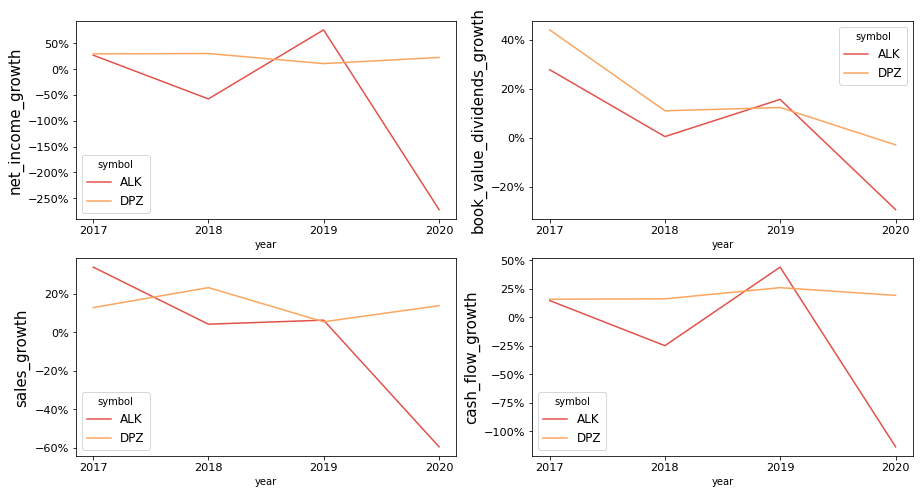

In [312]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(15,8))

sns.lineplot(data=df, x='year_datetime', y='net_income_growth', hue='symbol', ax=ax1)
sns.lineplot(data=df, x='year_datetime', y='book_value_dividends_growth', hue='symbol', ax=ax2)
sns.lineplot(data=df, x='year_datetime', y='sales_growth', hue='symbol', ax=ax3)
sns.lineplot(data=df, x='year_datetime', y='cash_flow_growth', hue='symbol', ax=ax4)

# Define the date format
date_form = mdates.DateFormatter("%Y")
for ax in [ax1, ax2, ax3, ax4]:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1, month=12, day=31))
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel('year', fontsize=10)


# Calculate the Windage Growth Rate
or the one growth rate to use for subsequent analysis

pg. 133 Invested

In [313]:
# Compare across growth rates
growth_rates = \
df.groupby('symbol').agg({'net_income_growth':['mean','std','median'],
                          'book_value_dividends_growth':['mean','std','median'],
                          'sales_growth':['mean','std','median'],
                          'cash_flow_growth':['mean','std','median']
                         })

# Calculate the overall growth rate we'll use in analysis as an average between our mean and medians for past several years
# and round down to the nearest ones/single digit percentage
growth_rates['windage_growth_rate'] = \
growth_rates[[('net_income_growth', 'mean'),('net_income_growth', 'median'),
              ('book_value_dividends_growth', 'mean'),('book_value_dividends_growth', 'median'),
              ('sales_growth', 'mean'),('sales_growth', 'median'),
              ('cash_flow_growth','mean'), ('cash_flow_growth', 'median')
             ]].mean(axis=1).round(decimals=2)

In [314]:
growth_rates.sort_values(by=['windage_growth_rate'], ascending=False)

net_income_growth                     book_value_dividends_growth  \
                    mean       std    median                        mean   
symbol                                                                     
DPZ             0.232527  0.090433  0.260293                    0.161933   
ALK            -0.567273  1.538845 -0.153550                    0.037249   

                           sales_growth                     cash_flow_growth  \
             std    median         mean       std    median             mean   
symbol                                                                         
DPZ     0.198252  0.117558     0.137698  0.072677  0.132664         0.193873   
ALK     0.246357  0.081424    -0.038016  0.394346  0.052142        -0.199031   

                           windage_growth_rate  
             std    median                      
symbol                                          
DPZ     0.047075  0.177744                0.18  
ALK     0.685481 -0.050621               -0.10

*^ Do these windage growth rates look reasonable? How do they compare with analysts' forecasts?*
- 

# Calculate Valuations

### Owners Earnings for Ten Cap
pg. 194 Invested  

Net Income   
\+ Depreciation & Amortization   
\+ Net Change in Accounts Receivables   
\+ Net Change in Accounts Payable   
\+ Income Tax   
\+ Maintainance Capital Expenditures  
= Owner Earnings

In [315]:
def owner_earnings_cap(row, cap=10):
    return (row['net_income'] \
         + row['depreciationAndAmortization'] \
         + row['net_accounts_receivable'] \
         + row['net_accounts_payable'] \
         + row['income_tax'] \
         + row['maintenance_capital_expenditure']) * cap

In [316]:
df['owner_earnings_ten_cap'] = df.apply(lambda row: owner_earnings_cap(row, 10), axis=1)

In [326]:
df.loc[df.reset_index().groupby(['symbol'])['year'].idxmin()][['year','symbol','owner_earnings_ten_cap']]

,year,symbol,owner_earnings_ten_cap
0,2020,ALK,-21730000000
5,2020,DPZ,5623290000


### Payback Time
pg. 201 Invested

Free Cash Flow grown by the compunded Windage Growth Rate for 8 years

In [327]:
df.columns

Index(['year', 'symbol', 'net_income', 'sales', 'income_tax', 'book_value',
       'dividendsPaid', 'operatingCashFlow', 'depreciationAndAmortization',
       'net_accounts_receivable', 'net_accounts_payable',
       'maintenance_capital_expenditure', 'book_value_plus_dividends',
       'year_datetime', 'net_income_growth', 'book_value_dividends_growth',
       'sales_growth', 'cash_flow_growth', 'owner_earnings_ten_cap'],
      dtype='object')

In [358]:
free_cash_flow_analysis = df.loc[df.reset_index().groupby(['symbol'])['year'].idxmin()][['year','symbol','freeCashFlow']]
free_cash_flow_analysis = free_cash_flow_analysis.merge(growth_rates[['windage_growth_rate']].reset_index(), on='symbol').rename(columns={('windage_growth_rate',''): 'windage_growth_rate'}).copy()

/home/caitriggs/anaconda3/envs/rule1investing/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/caitriggs/anaconda3/envs/rule1investing/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [359]:
free_cash_flow_analysis

,year,symbol,freeCashFlow,windage_growth_rate
0,2020,ALK,-440000000,-0.10
1,2020,DPZ,592794000,0.18
